# Laboratorio 9

In [1]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

from vega_datasets import data

alt.themes.enable('opaque')
%matplotlib inline

En este laboratorio utilizaremos un conjunto de datos _famoso_, el GapMinder. Esta es una versión reducida que solo considera países, ingresos, salud y población. 

¿Hay alguna forma natural de agrupar a estos países?

In [2]:
gapminder = data.gapminder_health_income()
gapminder.head()

,country,income,health,population
0,Afghanistan,1925,57.63,32526562
1,Albania,10620,76.00,2896679
2,Algeria,13434,76.50,39666519
3,Andorra,46577,84.10,70473
4,Angola,7615,61.00,25021974


## Ejercicio 1

(1 pto.)

Realiza un Análisis exploratorio, como mínimo un `describe` del dataframe y una visualización adecuada, por ejemplo un _scatter matrix_ con los valores numéricos.

In [3]:
gapminder.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,187,187,Turkey,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income,187,NaN,NaN,NaN,17232.2,19310.6,599,3585.5,10996,23834,132877
health,187,NaN,NaN,NaN,71.6733,7.74896,48.5,65.5,73.13,77.7,84.1
population,187,NaN,NaN,NaN,3.90889e+07,1.4329e+08,52993,2.24892e+06,8.54459e+06,2.76939e+07,1.37605e+09


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd915506c90>,
      dtype=object)

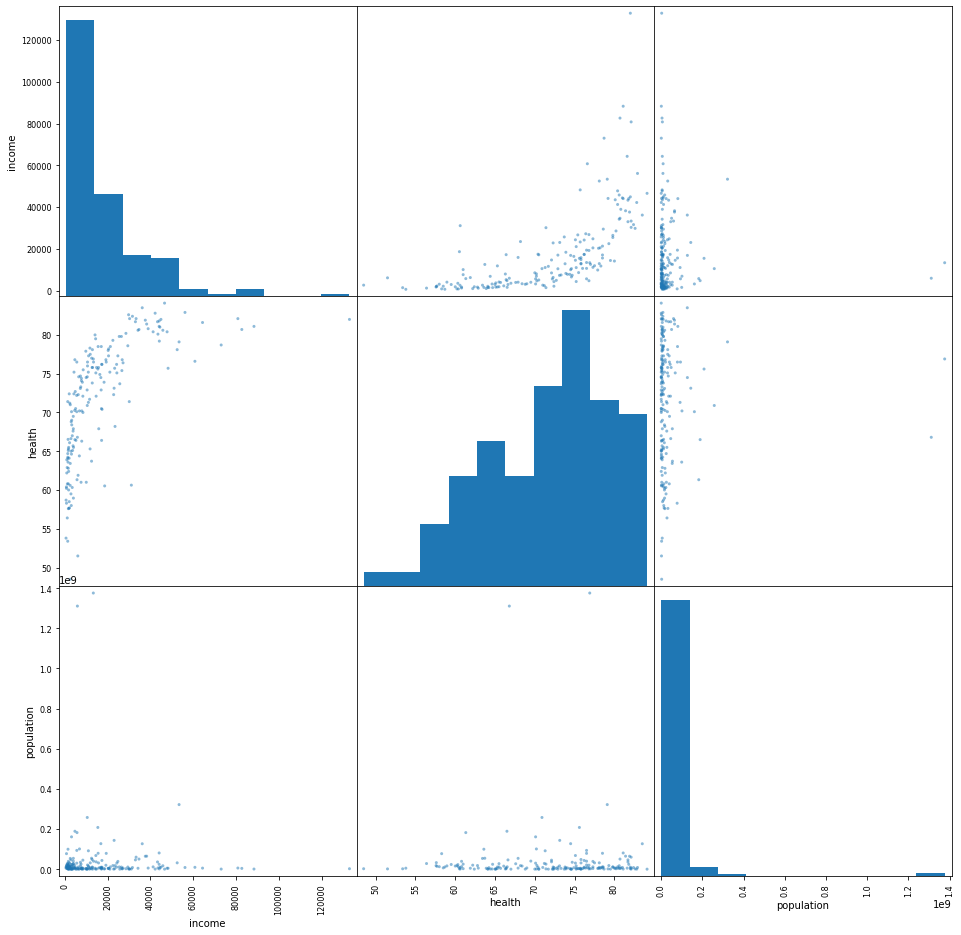

In [4]:
pd.plotting.scatter_matrix(gapminder, figsize=(16,16))

__Pregunta:__ ¿Hay alguna variable que te entregue indicios a simple vista donde se puedan separar países en grupos?

__Respuesta:__ Las variable 'income' y 'health' nos puede entregar una clusterización interesante.

## Ejercicio 2

(1 pto.)

Aplicar un escalamiento a los datos antes de aplicar nuestro algoritmo de clustering. Para ello, definir la variable `X_raw` que corresponde a un `numpy.array` con los valores del dataframe `gapminder` en las columnas _income_, _health_ y  _population_. Luego, definir la variable `X` que deben ser los datos escalados de `X_raw`.

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
X_raw = gapminder.drop('country', axis=1).to_numpy()
scaler = StandardScaler()
scaler.fit(X_raw)
X = scaler.transform(X_raw)

## Ejercicio 3

(1 pto.)

Definir un _estimator_ `KMeans` con `k=3` y `random_state=42`, luego ajustar con `X` y finalmente, agregar los _labels_ obtenidos a una nueva columna del dataframe `gapminder` llamada `cluster`. Finalmente, realizar el mismo gráfico del principio pero coloreado por los clusters obtenidos.


In [7]:
from sklearn.cluster import KMeans

In [8]:
colors = {0: 'red', 1: 'blue', 2: 'green'}
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_
gapminder["cluster"] = [colors[i] for i in clusters]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd908801c50>,
      dtype=object)

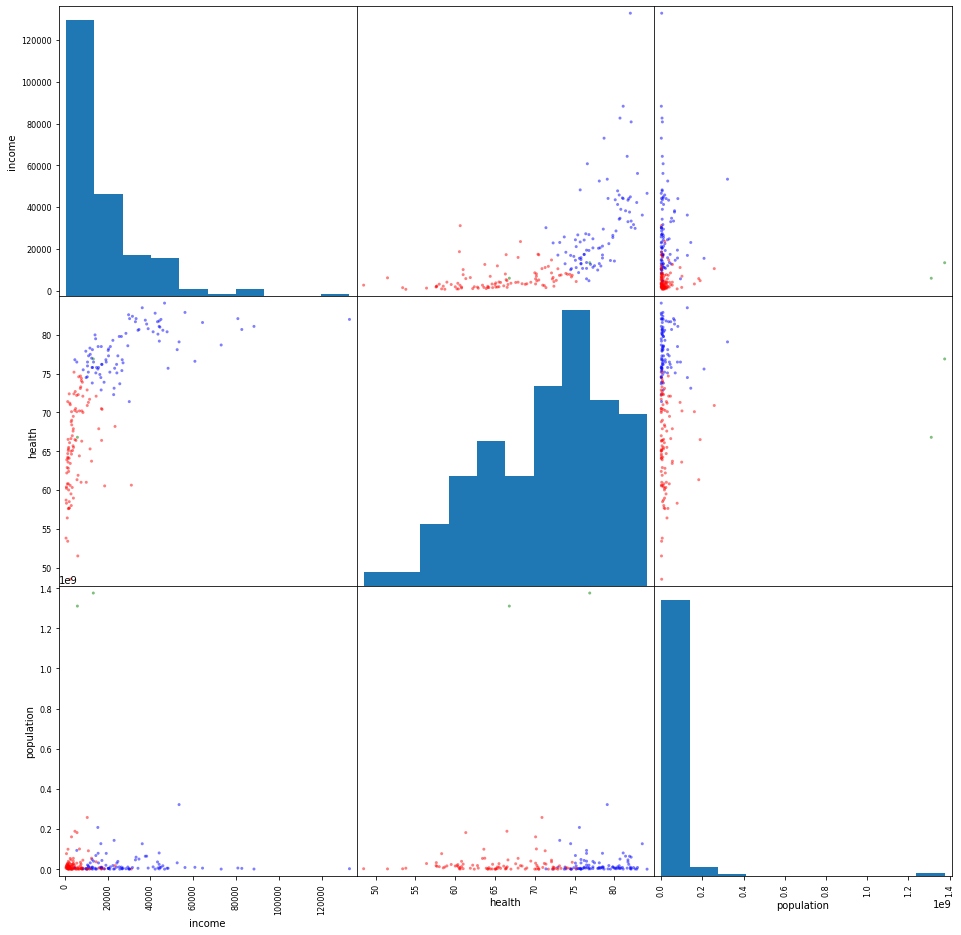

In [9]:
pd.plotting.scatter_matrix(gapminder, color=gapminder["cluster"], figsize=(16,16))

## Ejercicio 4

(1 pto.)

__Regla del codo__

__¿Cómo escoger la mejor cantidad de _clusters_?__

En este ejercicio hemos utilizado que el número de clusters es igual a 3. El ajuste del modelo siempre será mejor al aumentar el número de clusters, pero ello no significa que el número de clusters sea el apropiado. De hecho, si tenemos que ajustar $n$ puntos, claramente tomar $n$ clusters generaría un ajuste perfecto, pero no permitiría representar si existen realmente agrupaciones de datos.

Cuando no se conoce el número de clusters a priori, se utiliza la [regla del codo](https://jarroba.com/seleccion-del-numero-optimo-clusters/), que indica que el número más apropiado es aquel donde "cambia la pendiente" de decrecimiento de la la suma de las distancias a los clusters para cada punto, en función del número de clusters.

A continuación se provee el código para el caso de clustering sobre los datos estandarizados, leídos directamente de un archivo preparado especialmente.En la línea que se declara `kmeans` dentro del ciclo _for_ debes definir un estimador K-Means, con `k` clusters y `random_state` 42. Recuerda aprovechar de ajustar el modelo en una sola línea.

In [10]:
elbow = pd.Series(name="inertia", dtype="float64").rename_axis(index="k")
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state = 42).fit(X)
    elbow.loc[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
elbow = elbow.reset_index()

In [11]:
alt.Chart(elbow).mark_line(point=True).encode(
    x="k:O",
    y="inertia:Q"
).properties(
    height=600,
    width=800
)

alt.Chart(...)

__Pregunta:__ Considerando los datos (países) y el gráfico anterior, ¿Cuántos clusters escogerías?

__Respuesta:__ Escogería k = 3, pues es el punto donde "cambia la pendiente". Además, a partir de una visualización del gráfico entregado en el ejercicio 3, se puede observar que dificilmente se puede encontrar un cuarto clustering. (El tercer son los paises cuya población es superior al billón, es decir, China e India)